
# <font color=#2e86c1> Calculating NMR Parameters from MD Simulations 1: S$^2$ and C(t) </font>  

<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/JupyterBook/GNMR2025/MD2NMR_Colab.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

## Setup

In [1]:
# Make sure pyDR is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !git clone https://github.com/alsinmr/pyDR
else:
    os.chdir('../../..')

In [2]:
# Imports
import pyDR
vft=pyDR.MDtools.vft  #Set of tools for dealing with vectors
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from time import time

In [3]:
# Downloads
xtc='https://drive.google.com/file/d/1wq5T-YDmPo2zAIWu9we2zyL2i-v52fnD/view?usp=sharing'
pdb='https://drive.google.com/file/d/1aBMUO2C1AZfx05dANl4QITHuqmHbDDsN/view?usp=sharing'

if not(os.path.exists('ubi.pdb')):
    pyDR.IO.download(pdb,'ubi.pdb')
if not(os.path.exists('ubi.xtc')):
    pyDR.IO.download(xtc,'ubi.xtc')

In this tutorial, we want to calculate relaxation rate constants induced by reorientational motion of some NMR interaction tensor. We will consider $^{15}$N relaxation in the protein ubiquitin, where relaxation is induced by reorientation of the H–N dipole coupling and the $^{15}$N chemical shift anisotropy. The dipole coupling is parallel to the H–N bond, and the CSA can be approximated as parallel to this bond (in reality, it is about 23 $^\circ$ away, but the reorientational motion it experiences is about the same as the bond itself).

Then, we need to first extract the bond vectors, calculate order parameters and correlation functions, parameterize them, and calculate either rate constants directly, or compare parameters derived from NMR to parameters derived from MD.

## Part 1: The correlation function

As a brief review, we want to calculate order parameters and correlation functions from MD. For a normalized vector that gives the direction of an NMR tensor as a function of time ($\vec{v}(t)=[x(t),y(t),z(t)]$), we have for the correlation function:

$$
\begin{eqnarray}
C(t)&=&\left\langle P_2(\cos\beta_{\tau,t+\tau})\right\rangle_\tau \\
P_2&=&\frac{3x^2-1}{2} \\
\cos\beta_{\tau,t+\tau}&=&\vec{v}(\tau)\cdot\vec{v}(t+\tau) \\
&=&\sum\limits_{\alpha=x,y,z}{\alpha(\tau)\alpha(t+\tau)}
\end{eqnarray}
$$

The brackets $\langle ...\rangle_\tau$ indicate an average over $\tau$, where $C(t)$ is an average over all time points separated by $t$. $\cos\beta_{\tau,t+\tau}$ can be obtained from the dot-product of the normalized vectors at times $\tau$ and $t+\tau$.

The formula for $C(t)$ can be expanded and expressed as a sum of linear correlation functions, which will later be useful for faster calculations. Perform the steps below (check your results as you go)

### Exercise 1.1
Insert the summation for $x$ into $P2(...)$, and insert $P2(...)$ into the average brackets. Note that for an average, if we have constants $a$ and $b$, and variable $x$, then $\left\langle a+bx\right\rangle=a+b\langle x\rangle$. Apply this simplification for your result.

```{toggle}
$$
\begin{eqnarray}
C(t)&=&\left\langle-\frac12+\frac32\left(\sum\limits_{\alpha=[x,y,z]}{\alpha(\tau)\alpha(t+\tau)}\right)^2\right\rangle_\tau \\
&=&-\frac12+\frac32\left\langle\left(\sum\limits_{\alpha=[x,y,z]}{\alpha(\tau)\alpha(t+\tau)}\right)^2\right\rangle_\tau
\end{eqnarray}
$$
```

### Exercise 1.2 
A squared summation may be expanded by introducing a new index and summing over both indices, taking products of all terms, e.g. for $(\sum\limits_i{x_i})^2=\sum\limits_i{\sum\limits_j{x_ix_j}}$. Do this for the squared term above (you should have a double summation over $\alpha$ and $\beta$).

```{toggle}
$$
\begin{eqnarray}
C(t)&=&-\frac12+\frac32\left\langle\sum\limits_{\alpha=x,y,z}{\sum\limits_{\beta=x,y,z}{\alpha(\tau)\alpha(t+\tau)\beta(\tau)\beta(t+\tau)}}\right\rangle_\tau
\end{eqnarray}
$$
```

### Exercise 1.3
Finally, when we have the expectation value of a summation, this can be written as a sum of expectation values: $\left\langle\sum\limits_i{x_i}\right\rangle=\sum\limits_i{\langle x_i\rangle}$. Rewrite the total correlation function as a linear combination of linear correlation functions using this relationship.

```{toggle}
$$
\begin{eqnarray}
C(t)&=&-\frac12+\frac32\sum\limits_{\alpha=x,y,z}{\sum\limits_{\beta=x,y,z}{\left\langle\alpha(\tau)\beta(\tau)\alpha(t+\tau)\beta(t+\tau)\right\rangle_\tau}} \\
\end{eqnarray}
$$

Note that the term $\left\langle\alpha(\tau)\beta(\tau)\alpha(t+\tau)\beta(t+\tau)\right\rangle_\tau$ is an time *auto*correlation function of $\alpha(\tau)\beta(\tau)$ with itself.
```

## Part 2: Extract vectors
In this section, we need to get bond vectors for the H-N bonds that can be used for calculating the correlation function. 

Note that when calculating a bond's orientation, one needs to make sure that it is not split over the MD simulation's box (i.e. periodic boundary conditions). In this simulation, we use a molecule that has been made "whole", so that this is already fixed.

In some simulations, it may also be important to remove overall motion of the molecule, i.e. translation and rotation, by aligning it to a reference structure. If we remove this motion, then we should also remove it from the experimental data. For example, in solution NMR, usually it is best to solve for the total rotation of the molecule and factor out this motion for analysis, and also align the molecule in MD. Alternatively, we can leave the tumbling in both simulation and experimnt, but then we need to be sure the overall motion in MD is accurate, otherwise it will be a major source of error. On the other hand, for molecules like lipids in membranes, usually we want to keep the overall motion and so will not perform an alignment step. For intrinsically disordered proteins (IDPs), the overall motion presents a particular challenge because it can be hard to reproduce, but it is also not really possible to separate internal from overall motion in IDPs.

Below, we'll calculate correlation functions and order parameters with and without removing the overall motion.

[MDAnalysis](https://www.mdanalysis.org/) is a frame reader. One provides it with the location of a topology (that is, a file that tells how atoms in a system are bonded together, possibly containing multiple molecules), and a trajectory, which is a list of positions of those atoms as a function of time. The frame reader reads out the positions of those atoms (or a subset of those atoms as instructed) for a given frame. In MDanalysis, one has a universe *object* which gives access to all information about the simulation. Within the universe, one finds the "trajectory" object, which may be indexed to go to different frames in the trajectory. One may create atom groups from the universe, which then return positions of only selected atoms.

In [4]:
uni0=mda.Universe('ubi.pdb','ubi.xtc')

### Part 2.1 Align molecules

When we analyze an MD simulation, sometimes some preparation of the simulation is required. For example, if we are interested in studying internal motion of a protein, then we need to be aware if the protein is tumbling in solution. For a membrane protein, it will usually not be tumbling isotropically, although it may move within the membrane. Then, the question arises if we want to include this overall motion in our analysis, or exclude it via alignment of the molecule.

### Exercise 2.1
What type of biomolecules would you want to include overall motion, i.e. not apply alignment of the molecule?
```{toggle}
Molecules where it is difficult to define alignment, i.e. where the structure is highly variable. Two possibilities are intrinsically disordered proteins and lipid membranes.
```

A second concern is the periodic boundary condition (PBC) used in MD simulations. For an MD simulation, we have to restrict the simulation to a box. When an atom reaches the end of the box, it does not interact with a wall or a vacuum, but rather it interacts with atoms on the opposite side of the box. This is a convenient trick for keeping realistic interactions without requiring an extremely large system. However, a molecule may well be split across the box. This does not impact the simulation in any negative way, but makes the direction of a bond ill-defined. One may either prepare the simulation before analysis such that the molecule of interest stays "whole" or "centered", both usually avoid this problem. Alternatively, one may correct for bonds split across the box during analysis (pyDR, which we use later, treats the PBC automatically. It does not automatically handle alignment).

### Exercise 2.2
The following code aligns a molecule in a trajectory (assuming it is already made "whole", with no atoms crossing the periodic boundary condition), and writes it into a new file. When we align a molecule, we need to move atoms in the simulation to the center (translation), and turn them so that reference atoms are aligned (rotation). Which lines below achieve translation and rotation?

```{toggle}
translation: `pos-=ref.mean(0)`

rotation: `pos_corr=(R.T@pos.T).T`
```

Note that the rotational alignment below is achieved with the [Kabsch Algorithm](https://en.wikipedia.org/wiki/Kabsch_algorithm).

In [5]:
def align(uni,fileout='ubi_aligned.xtc',ref_sel='name CA'):
    """
    This function takes a trajectory and aligns it based on
    a reference selection of atoms. The new trajectory is
    returned in fileout (default is ubi_aligned.xtc)
    """
    
    from scipy.linalg import svd
    
    uni.trajectory[0] #Go to the first frame of the trajectory
    atoms=uni.atoms   #All atoms in the trajectory
    ref_sel=uni.select_atoms(ref_sel)  #Atom group for the reference
    
    ref0=ref_sel.positions #initial positions of reference atoms
    ref0-=ref0.mean(0) #Centers the initial position
    
    with mda.Writer(fileout,atoms.n_atoms) as W:
        for ts in uni.trajectory:
            ref=ref_sel.positions
            pos=atoms.positions

            pos-=ref.mean(0)   #This centers the atoms
            ref-=ref.mean(0)   #This centers the reference
            
            H=ref0.T@ref       #3x3 matrix
            U,S,Vt=svd(H)      #Singular value decomposition
            V=Vt.T             #Transposes
            Ut=U.T

            R=V@Ut             #Rotation matrix for alignment
            
            pos_corr=(R.T@pos.T).T
            atoms.positions=pos_corr
            
            W.write(atoms)
    return

In [6]:
align(uni0,'ubi_aligned.xtc')   #Runs the code to align Ubiquitin in the universe

In [7]:
uni=mda.Universe('ubi.pdb','ubi_aligned.xtc')  #Loads the aligned trajectory

### Part 2.2 Extract vectors

We're interested in reorientational motion of the H–N dipole coupling (and $^{15}$N CSA, but we'll assume this motion is also defined by the dipole). Then, we can define the dipole tensor's direction from the H–N bond vector. We first select atoms below (names N and H), noting that we have to be careful not to use the first residue, which does not have an "H" type atom, and also avoid prolines.

In [8]:
# We will let N and H define our bonds
def load_v(uni):
    N=uni.select_atoms('name N and not resname PRO and resid 2-76') #Only nitrogen with bound 1H
    H=uni.select_atoms('name H and resid 2-76')
    resi=N.resids

    v=[]   #Storage for bond vectors
    for k in range(len(uni.trajectory)):
        uni.trajectory[k]
        v.append(H.positions-N.positions) #N x 3 vector
    return resi,np.array(v)  #This creates a numpy array, which is nicer for calculation
    
resi,v=load_v(uni)
print(f'The shape of v is {v.shape[0]}x{v.shape[1]}x{v.shape[2]}, corresponding to time, bonds, and (x,y,z)')

The shape of v is 19401x72x3, corresponding to time, bonds, and (x,y,z)


### Exercise 2.3
Which line in the above code goes to the correct frame in the trajectory?
```{toggle}
`uni.trajectory[k]
```
What happens to H.positions or N.positions if you put different values in where `k` is?
```{toggle}
The positions are adjusted to match the given frame
```

In [9]:
# Use this cell to experiment with the frame reader

### Part 2.3 Normalize vectors
Note that depending how a trajectory is stored, it may also be necessary to perform periodic boundary condition corrections. For this trajectory, it is not necessary.


### Exercise 2.4
However, we do need to have normalized bond vectors in order to calculate the desired correlation functions. Below, a function is started for you to perform this normalization. To complete the function, you need to calculate the length of all vectors. The *x*-, *y*-, and *z*- components of the vector may be accessed via `v[:,:,0]`, `v[:,:,1]`, and `v[:,:,2]` respectively (dimensions are time, bond, and axis, so we need to access the last axis). Note that in Python, `**` raises a value to a power, and `np.sqrt()` can be used to calculate the square root.

In [ ]:
def norm(v):
    lv=                   #Length of the vectors goes here
    return (v.T/lv.T).T   #Normalize v (transposes required to correctly use "broadcasting")

v=norm(v)

In [11]:
def norm(v):
    lv=np.sqrt(v[:,:,0]**2+v[:,:,1]**2+v[:,:,2]**2)  #Length of the vectors
    return (v.T/lv.T).T   #Normalize v (transposes required to correctly use "broadcasting")

v=norm(v)

### Part 2.4 Plot the vectors

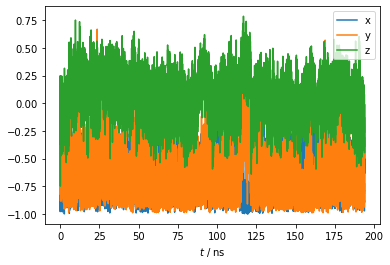

In [18]:
t=np.arange(v.shape[0])*uni.trajectory.dt/1e3
ax=plt.subplots()[1]
for q in range(3):
    ax.plot(t,v[:,10,q])
ax.legend(('x','y','z'))
_=ax.set_xlabel(r'$t$ / ns')

## Part 3: Order Parameters

Based on the vectors calculated in the previous section, we are now ready to calculate order parameters. 

Order parameters can be somewhat tricky in NMR, because in fact we have two different definitions for the order parameter. The first is that $S^2$ is the limit of the correlation function above, as $t$ approaches infinity

$$
S^2=\lim_{t\rightarrow\infty}{C(t)}
$$

The second definition defines $S$, we'll denote it as $S_{resid.}$ for clarity, and is given by:
$$
S_{resid.}=\frac{\delta}{\delta_{rigid}}
$$

$\delta$ is the motionally averaged anisotropy of an NMR interaction, whereas $\delta_{rigid}$ is the rigid limit of that interaction.

Typically, these two values are very similar ($S_{resid.}^2\approx S^2$), but they do not need to be exactly the same.

To derive a formula for $S^2$, we start from the definition of the correlation function above.

$$
\begin{eqnarray}
S^2=\lim_{t\rightarrow\infty}{C(t)}&=&\lim_{t\rightarrow\infty}{\left(-\frac12+\frac32\sum\limits_{\alpha=x,y,z}{\sum\limits_{\beta=x,y,z}{\left\langle\alpha(\tau)\alpha(t+\tau)\beta(\tau)\beta(t+\tau)\right\rangle_\tau}}\right)}
\end{eqnarray}
$$

The term $\langle \alpha(\tau)\beta(\tau)\alpha(t+\tau)\beta(t+\tau)\rangle$ is related to the correlation of $\alpha(\tau)\beta(\tau)$ with itself two times with infinite separation between them. Due to the infinite time separation, the correlation must go to zero. Then, for uncorrelated variables $x$ and $y$, we have the following relationship: $\langle xy\rangle=\langle x\rangle\langle y\rangle$. 

### Exercise 3.1
Use this relationship to rewrite the formula above.

```{toggle}
$$
\begin{eqnarray}
S^2&=&\lim_{t\rightarrow\infty}{\left(-\frac12+\frac32\sum\limits_{\alpha=x,y,z}{\sum\limits_{\beta=x,y,z}{\left\langle\alpha(\tau)\beta(\tau)\right\rangle_\tau\left\langle\alpha(t+\tau)\beta(t+\tau)\right\rangle_\tau}}\right)}
\end{eqnarray}
$$
```

In your answer above, the term $\langle \alpha(t+\tau)\beta(t+\tau)\rangle_\tau$ should occur. The $\langle ...\rangle_\tau$ indicates an average over all times. Then $t$ just shifts the times, but we still average over all times, so the term $t$ may be dropped. 

### Exercise 3.2
Simplify the formula based on this information. Note that if $t$ does not appear in the formula anymore, then one may also drop the limit for $t\rightarrow\infty$

```{toggle}
$$
\begin{eqnarray}
S^2&=&-\frac12+\frac32\sum\limits_{\alpha=x,y,z}{\sum\limits_{\beta=x,y,z}{\left\langle\alpha(\tau)\beta(\tau)\right\rangle_\tau^2}}
\end{eqnarray}
$$

```

For the latter formula ($S_{resid.}$), we must calculate the dipole tensor for all frames, take its average, and extract the anisotropy of the resulting averaged tensor. 

We introduce functions below for performing both calculations.

In [19]:
def S2(v):
    v=v.T #Make sure first dimension is x,y,z
    S2=-1/2
    for alpha in v:      #Loop over x,y,z
        for beta in v:  #Loop over x,y,z
            S2+=3/2*(alpha*beta).mean(axis=-1)**2
    return S2

def Sresid(v):
    v=v.T
    euler=vft.getFrame(v)
    A=vft.pars2Spher(1,0,*euler)   #We can set the reference value here to 1
    Aavg=A.mean(axis=-1)
    delta,eta,*euler=vft.Spher2pars(Aavg) #Then, delta is delta/delta_rigid
    return delta

### Exercise 3.3
Variables `a` and `b` should store the results for calculating $S^2$ (the limit of the correlation function for $t\rightarrow\infty$), and $S^2_{resid.}$ (calculated from the residual dipole coupling). Compare the two definitions of the order parameter.

In [ ]:
a=    #Calculation for S2 here
b=   #Calculation for (Sresid)^2 here

ax=plt.subplots()[1]
ax.plot(resi,a,color='red')
ax.plot(resi,b,color='black',linestyle='--')
ax.set_ylim([0,1])
ax.set_xlabel('Residue')
ax.legend((r'$S^2$',r'$S^2_{resid.}$'))
_=ax.set_ylabel(r'$S^2$')

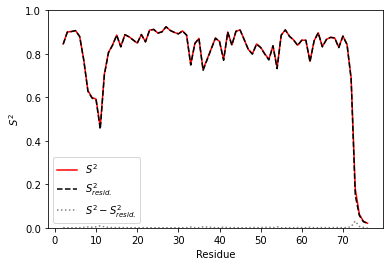

In [20]:
a=S2(v)    #Calculation for S2 here
b=Sresid(v)**2   #Calculation for (Sresid)^2 here

ax=plt.subplots()[1]
ax.plot(resi,a,color='red')
ax.plot(resi,b,color='black',linestyle='--')
ax.plot(resi,a-b,color='grey',linestyle=':')
ax.set_ylim([0,1])
ax.set_xlabel('Residue')
ax.legend((r'$S^2$',r'$S^2_{resid.}$',r'$S^2-S^2_{resid.}$'))
_=ax.set_ylabel(r'$S^2$')

If our motion has a symmetry axis (3-fold or higher), then $S^2=(S_{resid.})^2$, whereas otherwise, this relationship is only approximate. Note that if our motion has a symmetry axis, and we know the direction of that axis, then we may define $\beta$ as the angle between the tensor and the symmetry axis, in which case

$$
\begin{eqnarray}
S^2=(S_{resid.})^2&=&\left\langle\frac{3\cos^2\beta_{sym.}-1}{2}\right\rangle_\tau^2 \\
&=&\left\langle\frac{3z_{sym.}^2-1}{2}\right\rangle_\tau^2
\end{eqnarray}
$$

Here, $z_{sym.}$ is the projection of the normalized tensor direction onto the symmetry axis, which gives the cosine of the angle between the symmetry axis and the tensor. This is particularly useful in lipid membranes, where we know that the lipid rotates around the membrane normal and so the motion is necessarily symmetric around the normal.

### Exercise 3.4
What, approximately, is the asymmetry parameter ($\eta$) for residual dipole couplings used to calculate $S_{resid}$ above? 

Bonus points: Plot the asymmetry

```{toggle}
Given the near perfect agreement between the two definitions, we know the motions are roughly symmetric, and therefore the asymmetry parameter should be approximately zero.

If you're paying attention, you'll notice that in the function for `Sresid`, the asymmetry parameter, `eta`, is already calculated. You just need to return it!

When you do, you'll notice a fairly large value for $\eta$ at residue 73. The order parameters still appear to agree fairly well only because they are fairly small. In reality, there's a 21% disagreement between the two parameters
```


For residue 73, (S2-S2_resid)/S2_resid = 21 %


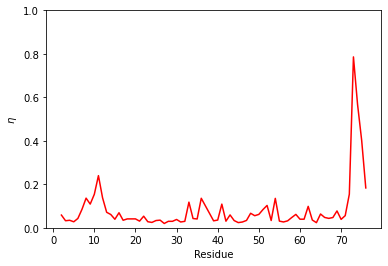

In [21]:
def Asymmetry(v):
    v=v.T
    euler=vft.getFrame(v)
    A=vft.pars2Spher(1,0,*euler)   #We can set the reference value here to 1
    Aavg=A.mean(axis=-1)
    delta,eta,*euler=vft.Spher2pars(Aavg) #Then, delta is delta/delta_rigid
    return eta

eta=Asymmetry(v)    #Calculation for S2 here

ax=plt.subplots()[1]
ax.plot(resi,eta,color='red')
ax.set_ylim([0,1])
ax.set_xlabel('Residue')
_=ax.set_ylabel(r'$\eta$')

i=np.argmax(eta)
print(f'For residue {resi[i]}, (S2-S2_resid)/S2_resid = {(a[i]-b[i])/b[i]*100:.0f} %')

### Exercise 2.2 Repeat with un-aligned trajectory
Repeat the above calculation of the order parameters, but use uni0, which contains the unaligned trajectory. Explain the result.

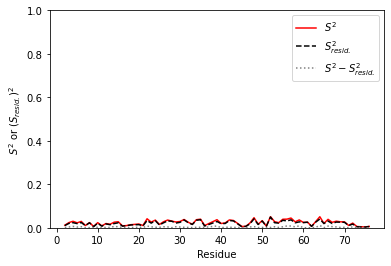

In [22]:
_,v0=load_v(uni0)
v0=norm(v0)

a=S2(v0)    #Calculation for S2 here
b=Sresid(v0)**2   #Calculation for (Sresid)^2 here

ax=plt.subplots()[1]
ax.plot(resi,a,color='red')
ax.plot(resi,b,color='black',linestyle='--')
ax.plot(resi,a-b,color='grey',linestyle=':')
ax.set_ylim([0,1])
ax.set_xlabel('Residue')
ax.legend((r'$S^2$',r'$S^2_{resid.}$',r'$S^2-S^2_{resid.}$'))
_=ax.set_ylabel(r'$S^2$')

ax.set_ylim([0,1])
ax.set_xlabel('Residue')
_=ax.set_ylabel(r'$S^2$ or $(S_{resid.})^2$')

```{toggle}
The tumbling of the ubiquitin in solution is included in the order parameter calculations, yielding a nearly isotropic motion, represented by order parameters that are nearly zero.
```

## Part 4: Correlation functions

Below, we provide two functions for calculating a linear correlation function (the correlation function we require is not linear, but can be recast as a sum of linear correlation functions). The first calculates the correlation function simply according to its definition, the second uses the fast-Fourier transform.

### Exercise 4.1
Test the two functions and see which one is faster. We need, for example, the correlation function $\langle x(\tau)y(\tau)x(t+\tau)y(t+\tau)\rangle$, which is the autocorrelation function for $x(t)y(t)$, which can be obtained by inserting `v[:,0]*v[:,1]` into the functions. By how much is it faster? You can sandwich your code as follows to get the time:

```
t0=time()
...
print(time()-t0)
```

Bonus: Why is this code faster? And why can we use the Fourier transform to get a correlation function?


In [23]:
# Classic approach for calculating a linear correlation function
def ct_lin(x):
    x=x.T                     #We want the time axis to come first
    ct=[]                     #list to store the correlation function
    for k in range(len(x)):   #Loop over all time points
        if k==0:              #Indexing below will fail for k==0, so make special case
            ct.append((x**2).mean(axis=0))   #k==0 pairs all elements with themselves, takes mean
        else:
            ct.append((x[:-k]*x[k:]).mean(axis=0)) #Pairs each element with term k elements later
    return np.array(ct).T     #Turn into a numpy array for easier calculation, tranpose

# Fourier transform-based approach for calculating a linear correlation function
def ct_ft(x):
    sz=x.shape[-1]
    X=np.fft.fft(x,n=sz*2)
    
    ct=np.fft.ifft(X.conj()*X)[:,:sz].real.T
    return ct.T/np.arange(sz,0,-1)

In [20]:
# Run your calculations here

In [21]:
t0=time()
ct0=ct_lin(v.T[0]**2)
print(f'Standard ct: {time()-t0:.2f} s')

t0=time()
ct1=ct_ft(v.T[0]**2)
print(f'FT-ct: {time()-t0:.2f} s')

Standard ct: 9.02 s
FT-ct: 0.37 s


```{toggle}
The Fourier transform is on the order of 30-40 times faster, a significant speed up. 

FFT is faster because the Fourier transform algorithm is highly optimized, and also because it's not actually running in Python. Numpy calculations are usually running in compiled linear algebra libraries written in C and FORTRAN, so are much faster than non-compiled python code (the "for" loop in ct_lin adds most of the computational time).

We can use FFT based on the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem). Note that because we have a finite time axis, we end up with a circular convolution, which must be treated by zero-filling the function (`n=sz*2`) and renormalizing the result (`/np.arange(sz,0,-1)`)
```

### Exercise 4.2
Finish the function below to get the total correlation function (you will need the answer to exercise 1.3). The `+=` sign adds whatever is right of the equals sign to the variable itself (`ct+=x` is equivalent to `ct=ct+x`). Which linear correlation function should you use? Note that we take the transpose of the matrix at the beginning, so the first dimension of the vectors, `v`, corresponds to x (`v[0]`), y (`v[1]`), and z (`v[2]`).

In [ ]:
def Ct(v):
    v=v.T
    ct=-1/2*np.ones(v.shape[1:])
    
    # Add up 9 linear correlation functions
    for k in range(3):
        for j in range(3):  
            ct+=
    return ct

In [24]:
def Ct(v):
    v=v.T
    ct=-1/2*np.ones(v.shape[1:])
    
    for k in range(3):
        for j in range(3):
            ct+=3/2*ct_ft(x=v[k]*v[j])  
    return ct

# 33% faster
def Ct(v):
    v=v.T
    ct=-1/2*np.ones(v.shape[1:])
    
    
    for k in range(3):
        for j in range(k,3):   #This loop goes over a total of 6 instead of 9 elements
            if k==j:
                ct+=3/2*ct_ft(x=v[k]*v[j])  #Double this account for skipped elements
            else:
                ct+=3*ct_ft(x=v[k]*v[j])  #Double this account for skipped elements
    return ct

In [25]:
s2=S2(v)
t0=time()
ct=Ct(v)
t=np.arange(len(uni.trajectory))*uni.trajectory.dt/1e3  #Time axis in nanoseconds
print(time()-t0)

2.0796608924865723


Selected correlation functions are plotted below, along with the order parameters as dashed lines. The code `resi[0:-1:8]` goes from the first residue to the last residue, in steps of 8. You can look at other residues by changing this (`resi[0:9:1]` shows you the first 8 residues, `resi[-9:]` shows you the last 9 residues, and so on). You may also need to adjust the y-limits if you select different residues (last line).

Note that if your correlation functions do not start at 1, and do not end at approximately the order parameter, then you need to re-check your correlation function definition.

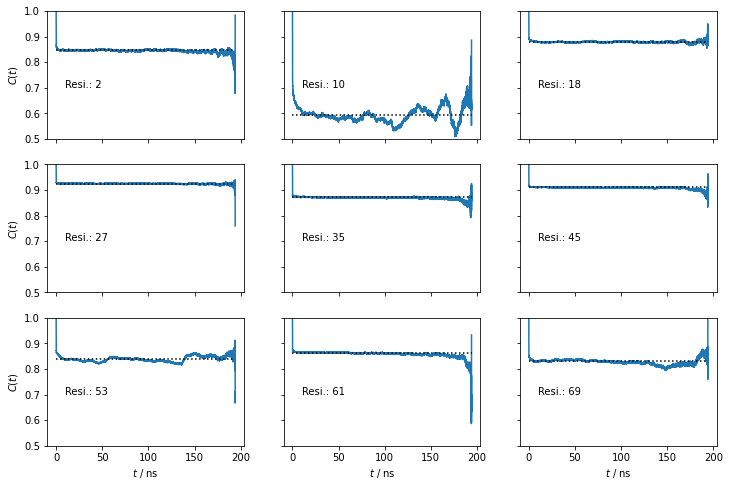

In [24]:
fig,ax=plt.subplots(3,3,sharex=True,sharey=True,figsize=[12,8])
ax=ax.flatten()
for r,a in zip(resi[::8],ax):
    a.plot(t,ct[resi==r].flatten())
    a.plot(t[[0,-1]],s2[resi==r].flatten()*np.ones(2),color='black',linestyle=':')
    a.text(10,.7,f'Resi.: {r}')
    if a.is_last_row():
        a.set_xlabel(r'$t$ / ns')
    if a.is_first_col():
        a.set_ylabel(r'$C(t)$')
    
_=ax[0].set_ylim([0.5,1])

### Exercise 4.3
Why do the correlation functions become noisy towards the end?

```{toggle}
There are two reasons:

First, the last point is calculated by pairing the first element of the trajectory with the last, so there is no averaging, and 100 points from the end, there are only 100 points averaged, vs. in this example, 19401 points for the first element. So the closer we are to the end, the fewer pairs of points that are averaged.

However, this hardly accounts for the noise halfway through the trajectory, where the noise level should only be $\sqrt{2}$ higher than at the beginning. This is because slow events, which have a long correlation time, do not occur frequently enough. If an event takes 10 ns on average, then over 194 ns, it occurs about 19 times, but it can very easily be a few more times or a few less, which introduces additional noise especially for bonds with slower motion present.
```

### Include tumbling
Below, we compare to the correlation function with tumbling

In [25]:
ct0=Ct(v0)

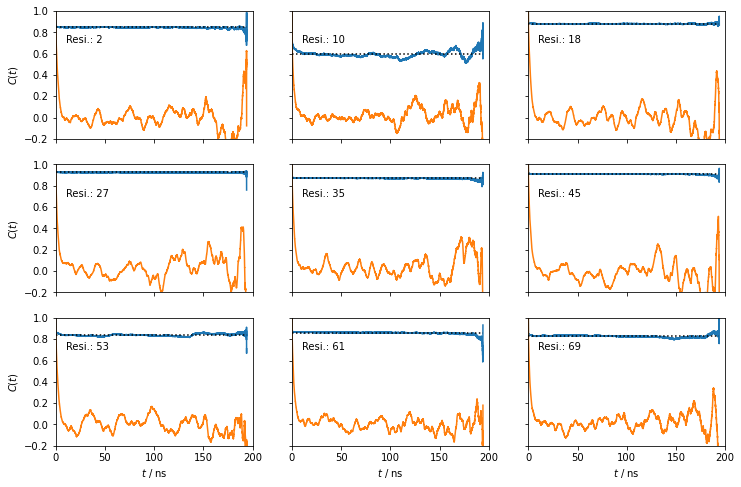

In [26]:
fig,ax=plt.subplots(3,3,sharex=True,sharey=True,figsize=[12,8])
ax=ax.flatten()
for r,a in zip(resi[::8],ax):
    a.plot(t,ct[resi==r].flatten())
    a.plot(t,ct0[resi==r].flatten())
    a.plot(t[[0,-1]],s2[resi==r].flatten()*np.ones(2),color='black',linestyle=':')
    a.text(10,.7,f'Resi.: {r}')
    if a.is_last_row():
        a.set_xlabel(r'$t$ / ns')
    if a.is_first_col():
        a.set_ylabel(r'$C(t)$')
ax[0].set_ylim([-.2,1])
_=ax[0].set_xlim([-5,200])

### Exercise 4.4
What is different about the correlation functions with tumbling? Estimate the correlation time of tumbling from the correlation functions. This is roughly when the correlation function crosses $1/e=0.37$. You may want to adjust the x-limit of the plot to see this better. Technically, you should look for $S^2/e$, but for our purposes, 1/e is sufficient.

```{toggle}
All correlation functions decay near to zero in the first few nanoseconds. This is mostly the tumbling in solution. The correlation time is around 2.5 ns. This is actually too short compared to experiment, where we observe a correlation time of about 4.8 ns. MD often struggles to produce the correct correlation time of tumbling, which is one reason to remove it via alignment of the molecule.
```